<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Standard-Packages" data-toc-modified-id="Import-Standard-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Standard Packages</a></span></li><li><span><a href="#Import-Symawofo-Packages" data-toc-modified-id="Import-Symawofo-Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Symawofo Packages</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Add-Additional-Features" data-toc-modified-id="Add-Additional-Features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Add Additional Features</a></span></li><li><span><a href="#Construct-Base-Model" data-toc-modified-id="Construct-Base-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Construct Base Model</a></span></li><li><span><a href="#Define-all-the-SubStrats" data-toc-modified-id="Define-all-the-SubStrats-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define all the SubStrats</a></span></li><li><span><a href="#Train/Test-the-SubStrats" data-toc-modified-id="Train/Test-the-SubStrats-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train/Test the SubStrats</a></span></li><li><span><a href="#Logs" data-toc-modified-id="Logs-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Logs</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Clustering</a></span></li></ul></div>

# Import Standard Packages

In [1]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from pathlib import Path
from copy import deepcopy
from datetime import datetime
import dill
from tqdm.auto import tqdm
import json
from itertools import combinations

# internal
import sys
sys.path.append(r"/home/osindi/ami")
sys.path.append(r"/home/osindi/Symawofo")
sys.path.append(r"C:\SyMAWoFlo\Symawofo")
sys.path.append(r"C:\Users\amoniri\PycharmProjects\Symawofo")
sys.path.append(r"C:\Users\amoniri\PycharmProjects\ami")

# Import Symawofo Packages

In [2]:
from symawofo import make_pipeline, WindowFrame, DataSplitter, FeatureFrame, FeatureSeries
from symawofo.transformers import Lag, Difference, StandardScaler, TransformedTargetRegressor, Clipper, Pipeline
from symawofo.model_selection.sk import GridSearchCV
from symawofo.models.base import model as model_dec, RegressorMixin2d, BaseModel
from symawofo.signals.wf import ThresholdSignSignal
from symawofo.pnl.base import AssetType
from symawofo.metrics import make_scorer
from symawofo.pnl import PNL
from symawofo.shared.utils import to_pickle, read_pickle

In [3]:
from symawofo import get_client
client = get_client('local')

/home/osindi/env/symawofo2/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43895 instead
  warnings.warn(


# Load Data

In [4]:
df_master_daily = pd.read_csv('Transformed_Data.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
df_master_daily = df_master_daily.join(pd.read_csv('DXY.csv', index_col=0))
df_master_daily['US_Equity_Real_Vol1m'] = np.exp(df_master_daily['US_Equity_Fut']).pct_change().rolling(21).std()*np.sqrt(252)
df_master_daily['US_AUD_Eq3m'] = (np.exp(df_master_daily['US_Equity']).pct_change(63) - np.exp(df_master_daily['AUD_Equity']).pct_change(63)).shift(1)


df_master_weekly = df_master_daily[df_master_daily.index.weekday==4].copy() # Convert to weekly! Fridays (i.e. .resample('W-FRI').last())
df_master_weekly.tail()

UK_Equity_Vol  SEK_Equity_Vol  JPN_Nikkei_PE  US_Credit_IG_OAS  \
2020-06-26          26.89           27.14        27.4870          0.693702   
2020-07-03          23.02           24.31        27.2690          0.658068   
2020-07-10          23.60           23.92        27.2499          0.641216   
2020-07-17          21.56           22.09        27.7457          0.633169   
2020-07-24          21.74           22.02        27.8132          0.622158   

            US_Credit_HY_OAS  JPN_Credit_IG_OAS  EMU_Credit_IG_OAS  \
2020-06-26          6.153414           0.624857           0.754222   
2020-07-03          6.003799           0.623595           0.728486   
2020-07-10          5.967674           0.604368           0.726914   
2020-07-17          5.563074           0.608347           0.689635   
2020-07-24          5.042923           0.619334           0.640341   

            EMU_Credit_HY_OAS  UK_Credit_IG_OAS  UK_Credit_HY_OAS  ...  \
2020-06-26           5.316320          1.761242          6.900926  ...   
2020-07-03           5.225561          1.719609          6.835161  ...   
2020-07-10           5.249594          1.685940          6.926201  ...   
2020-07-17           5.072157          1.646381          6.825860  ...   
2020-07-24           4.816503          1.588846          6.715479  ...   

            JPY_CBBI_G_raw  JPY_CBEI_I_raw  JPY_CBBI_I_raw  USD_CBEI_G_raw  \
2020-06-26       45.721187       -1.588272       43.224932        1.298895   
2020-07-03       45.721187       -1.588272       43.224932        1.298895   
2020-07-10       45.721187       -1.588272       43.224932        1.298895   
2020-07-17       45.721187       -1.588272       43.224932        1.298895   
2020-07-24       45.721187       -1.588272       43.224932        1.298895   

            USD_CBBI_G_raw  USD_CBEI_I_raw  USD_CBBI_I_raw     DXY  \
2020-06-26       22.537034        0.878475       -7.529489  97.433   
2020-07-03       22.537034        0.878475       -7.529489  97.172   
2020-07-10       22.537034        0.878475       -7.529489  96.652   
2020-07-17       22.537034        0.878475       -7.529489  95.942   
2020-07-24       22.537034        0.878475       -7.529489  94.435   

            US_Equity_Real_Vol1m  US_AUD_Eq3m  
2020-06-26              0.278372     0.051223  
2020-07-03              0.282935     0.033982  
2020-07-10              0.190586     0.035914  
2020-07-17              0.189110     0.016102  
2020-07-24              0.163983    -0.021186  

[5 rows x 2863 columns]

# Add Additional Features

In [5]:
def zscore(x, w=10):
    return (x-x.rolling(w).mean())/x.rolling(w).std()


df_master_weekly['US_Equity_Fut_ChgP'] = np.exp(df_master_weekly['US_Equity_Fut']).pct_change()
df_master_weekly['US_Equity_Vol_Chg'] = df_master_weekly['US_Equity_Vol'].diff()
df_master_weekly['Mom_Change_SPX'] = df_master_weekly['US_Equity'].pct_change(4)*52/4 - df_master_weekly['US_Equity'].pct_change(52)
df_master_weekly['DXY_ChgP'] = df_master_weekly['DXY'].pct_change()
df_master_weekly['SPGSIN_Chg13'] = df_master_weekly['GLOB_Ind_metals'].diff(13)
df_master_weekly['eq_per_flows_USA'] = df_master_weekly['eq_per_flows_USA']
df_master_weekly['US_Equity_Real_Vol1m_Chg'] = df_master_weekly['US_Equity_Real_Vol1m'].diff()
df_master_weekly['US_Lois3m_Chg'] = df_master_weekly['US_Lois3m'].diff()
df_master_weekly['US_2y_v_OIS_ZSc52'] = zscore(df_master_weekly['US_2y_v_OIS'], 52)
df_master_weekly['US_Bond_30y_ZSc52'] = zscore(df_master_weekly['US_Bond_30y'], 52)
df_master_weekly['US_10y_2y_ZSc52'] = zscore((df_master_weekly['US_Bond_10y']-df_master_weekly['US_Bond_2y']), 52)
df_master_weekly['GLOB_EM_HCSp_Chg'] = df_master_weekly['GLOB_EM_HCSp'].diff()

df_master_weekly['US_HYIG_Spread'] = df_master_weekly['US_Credit_HY_OAS']-df_master_weekly['US_Credit_IG_OAS']

df_master_weekly['US_Credit_HY_OAS_Chg'] = df_master_weekly['US_Credit_HY_OAS'].diff()
df_master_weekly['US_Credit_HY_IG_Chg'] = df_master_weekly['US_Credit_IG_OAS'].diff()
df_master_weekly['US_HYIG_Spread_Chg'] = df_master_weekly['US_HYIG_Spread'].diff()
df_master_weekly['US_Credit_HY_OAS_ZSc52'] = zscore(df_master_weekly['US_Credit_HY_OAS'],52)
df_master_weekly['US_Credit_HY_IG_ZSc52'] = zscore(df_master_weekly['US_Credit_IG_OAS'],52)
df_master_weekly['US_HYIG_Spread_ZSc52'] = zscore(df_master_weekly['US_HYIG_Spread'],52)

In [6]:
df_master_weekly['FX_AUD_Daily_Carry_Ann'] = df_master_weekly['FX_AUD_Daily_Carry_Ann']
df_master_weekly['SPGSIN_Chg'] = df_master_weekly['GLOB_Ind_metals'].diff()
df_master_weekly['FX_AUD_TR_Chg'] = df_master_weekly['FX_AUD_TR'].diff()

In [7]:
from sklearn.svm import LinearSVR

In [10]:
SubStratSVR = model_dec(RegressorMixin2d)(LinearSVR)
model = SubStratSVR()
model

LinearSVR(_features_to_sample=[], _index_to_sample=[], _sample_weight_fn=None,
          lags=slice(0, 12, None))

# Construct Base Model

In [29]:
from sklearn.model_selection import ParameterGrid

@model_dec(RegressorMixin2d)
class SubStrat(sk.base.BaseEstimator):
    def __init__(self, param_grid, scoring):
        self.param_grid = ParameterGrid(param_grid)
        
        self.func = None
        self.thresh = None
        
        self.best_params_ = {'func': None, 'thresh': None, 'score': -np.inf}
        
        self.scorer = scoring
        
    def fit(self, X, y):
        
        for params in self.param_grid:
            self.func = params['func']
            self.thresh = params['thresh']
            score = self.scorer(y, self.predict(X).data)
            if score > self.best_params_['score']:
                self.best_params_['func'] = self.func
                self.best_params_['thresh'] = self.thresh
                self.best_params_['score'] = score
                
        self.func = self.best_params_['func']
        self.thresh = self.best_params_['thresh']

        return self
    
    def predict(self, X):
        return self.func(X, self.thresh)

from symawofo.models.sk.linear_model import LogisticRegression
def make_model(model_type, param_grid, scoring_func):
    my_model = SubStrat(lags=0, param_grid=param_grid, scoring=scoring_func)

    return my_model
    
# This is a signal class compatible with Symawofo for 'Buy&Hold' strategy
class LongOnly:
    def __init__(self, target, index):
        self.target = target
        self.index = index

    def get_signals(self):
        return pd.Series(np.ones(len(target)), index=target.data.index, dtype='float').reindex(self.index)
    
    
def long_only_relative_mean_score(y, y_pred):
    return np.mean(y_pred*y) - np.mean((1-y_pred)*y)

def long_short_relative_mean_score(y, y_pred):
    return np.mean(y_pred*y) - np.mean((1-y_pred)*y)

def mean_score(y, y_pred):
    return np.mean(y_pred*y)

def sharpe_score(y, y_pred):
    return np.mean(y_pred*y)/np.std(y_pred*y)

def active_mean_score(y, y_pred):
    idx = np.abs(y_pred)>0
    return np.mean(y_pred[idx]*y[idx])

def active_sharpe_score(y, y_pred):
    idx = np.abs(y_pred)>0
    return np.mean(y_pred[idx]*y[idx])/np.std(y_pred[idx]*y[idx])

def ctail_score(y, y_pred):
    strat = y_pred*y
    top_percentile = np.percentile(strat, 90)
    idx = strat>top_percentile
    return np.mean(strat[idx])

def short(fn):
    def wrapper(x, y):
        return -fn(x, y)
    return wrapper







def mixed(x, threshold): #param_grid_func
    return np.less(x, threshold).astype(float)-np.greater(x, threshold).astype(float)

def mixed(x, threshold): #param_grid_func
    return np.less(x, threshold).astype(float)-np.greater(x, threshold).astype(float)


def tent(x, threshold): #param_grid_func
    return np.greater(x, threshold).astype(float)-np.less(x, -threshold).astype(float)

def multi_tent(x, threshold): #param_grid_func
    return np.greater(x, threshold[1]).astype(float)-np.less(x, -threshold[0]).astype(float)



In [30]:
def active_mean_reg_score(y, y_pred):
    idx = np.abs(y_pred)>0
    return np.mean(y_pred[idx]*y[idx]) * np.log(np.sum(idx))

y = np.array([0.1, 0.1, -0.05, 0.2, -0.1])
y_pred_case1 = np.array([1, 0, 0, 0, 0])

active_mean_score(y, y_pred_case1)

0.1

# Define all the SubStrats

In [31]:
#  {'feature_name': 'US_Equity_Vol_Chg',
#    'param_grid': {'func': [np.greater], 'thresh': np.linspace(-2, 2, num=20)},
#  'feature_preprocessing': make_pipeline(StandardScaler(), Clipper(-3, 3), StandardScaler()),
#  'scoring_func': active_mean_reg_score},
                      

In [32]:
asset = 'FX_AUD_TR'

hyp = [('FX_AUD_Daily_Carry_Ann', '0', 'larger', '1'),
 ('SPGSIN_Chg13', '0.0', 'larger', '1'),
 ('SPGSIN_Chg', '0', 'larger', '1'),
 ('AUD_Trade_Bal', '0', 'larger', '1'),
 ('US_AUD_Eq3m', '0', 'larger', '-1'),
 ('CFTC_AUD_NonComm_NOI', '0', 'larger', '1'),
 ('US_2y_v_OIS_ZSc52', '0', 'larger', '-1')
      ]


substrat_meta_list = [
{'feature_name': 'FX_AUD_TR_Chg',
  'param_grid': {'func': [short(tent)], 'thresh': np.linspace(0, df_master_weekly['FX_AUD_TR_Chg'].quantile(0.75), num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
{'feature_name': 'FX_AUD_TR_Chg',
  'param_grid': {'func': [tent], 'thresh': np.linspace(0, df_master_weekly['FX_AUD_TR_Chg'].quantile(0.75), num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
{'feature_name': 'FX_AUD_Daily_Carry_Ann',
  'param_grid': {'func': [tent], 'thresh': np.linspace(0, 2, num=20)},
 'feature_preprocessing': make_pipeline(StandardScaler(), Clipper(-3, 3), StandardScaler()),
 'scoring_func': mean_score},
{'feature_name': 'FX_AUD_Daily_Carry_Ann',
  'param_grid': {'func': [tent], 'thresh': [0]},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
{'feature_name': 'SPGSIN_Chg13',
  'param_grid': {'func': [tent], 'thresh': np.linspace(0, df_master_weekly['SPGSIN_Chg13'].quantile(0.75), num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
{'feature_name': 'SPGSIN_Chg',
  'param_grid': {'func': [tent], 'thresh': np.linspace(0, df_master_weekly['SPGSIN_Chg'].quantile(0.75), num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
{'feature_name': 'AUD_Trade_Bal',
  'param_grid': {'func': [tent], 'thresh': np.linspace(0, df_master_weekly['AUD_Trade_Bal'].quantile(0.75), num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
{'feature_name': 'US_AUD_Eq3m',
  'param_grid': {'func': [short(tent)], 'thresh': np.linspace(0, df_master_weekly['US_AUD_Eq3m'].quantile(0.75), num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
{'feature_name': 'CFTC_AUD_NonComm_NOI',
  'param_grid': {'func': [tent], 'thresh': np.linspace(0, df_master_weekly['CFTC_AUD_NonComm_NOI'].quantile(0.75), num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score},
{'feature_name': 'US_2y_v_OIS_ZSc52',
  'param_grid': {'func': [short(tent)], 'thresh': np.linspace(0, 2, num=20)},
 'feature_preprocessing': None,
 'scoring_func': mean_score}
]

{'feature_name': 'US_2y_v_OIS_ZSc52',
  'param_grid': {'func': [mixed], 'thresh': np.linspace(-2, 2, num=20)},
 'feature_preprocessing': None,
 'scoring_func': active_mean_reg_score}

common_meta_dict = {
    'splitter': DataSplitter(test_size=13,
                             initial_training_size=52*2,
                             expanding=True,
                             last_training_window=True),
    'feature_preprocessing': None,
#     'feature_preprocessing': make_pipeline(StandardScaler()),
    'target_preprocessing': make_pipeline(Difference(), Lag(-1)),
    'scoring_func': lambda y, y_pred: np.mean(y_pred*y) - np.mean((1-y_pred)*y),
    'target_name': asset,
    'model_type': 'not_Substrat'
}

# Add common meta data to each entry in substrat_meta_list
for k, v in common_meta_dict.items():
    for i in range(len(substrat_meta_list)):
        if k not in substrat_meta_list[i]:  # Only override if it does not already exist
            substrat_meta_list[i][k] = deepcopy(v)

In [33]:
# df_master_weekly[['US_Equity_Fut_ChgP', 'DXY_ChgP']].plot(kind='scatter', x='US_Equity_Fut_ChgP', y='DXY_ChgP')

In [34]:
start_date = "2005"

fig, ax = plt.subplots(3, int(np.ceil(len(substrat_meta_list)/3)),
                       figsize=(10, 6), dpi=100)
ax = ax.flatten()
for i, meta in enumerate(tqdm(substrat_meta_list)):
    
    feature_name = meta['feature_name']
    target_name = meta['target_name']
    
    feature_preprocessing = meta['feature_preprocessing']
    target_preprocessing = meta['target_preprocessing']
    
    features = FeatureFrame(df_master_weekly[[feature_name]].loc[start_date:].copy().dropna())
    if feature_preprocessing is not None: 
        features = feature_preprocessing.fit_transform(features)
    
    target = FeatureFrame(df_master_weekly[[target_name]].loc[start_date:].copy().dropna()).squeeze()
    target = target_preprocessing.fit_transform(target)
    
    sns.regplot(x=target.data.values, y=features.data.values, ax=ax[i])
    ax[i].set(xlabel=target_name, ylabel=feature_name)
    
plt.tight_layout()
plt.show()

In [35]:
# for s in substrat_meta_list:
#     s['scoring_func'] = active_mean_reg_score

In [36]:

# spx_change_dict = {'feature_name': 'US_Equity_Fut_ChgP',
#                    'splitter': DataSplitter(test_size=25,
#                              initial_training_size=500,
#                              expanding=True,
#                              last_training_window=True),
#                    'target_preprocessing': make_pipeline(Difference(), Lag(-1)),
#                    'target_name': asset}



# scoring_list = [long_only_relative_mean_score, ctail_score, active_sharpe_score, active_mean_score, sharpe_score, mean_score]
# try1 = {'param_grid': {'func': [np.less, np.greater], 'thresh': np.linspace(-2, 2, num=20)},
#         'feature_preprocessing': make_pipeline(StandardScaler(), Clipper(-3, 3), StandardScaler())}

# try2 = {'param_grid': {'func': [np.less, np.greater], 'thresh': np.linspace(-0.05, 0.05, num=20)},
#         'feature_preprocessing': None}


# spx_change_dict_list = []
# for scoring in scoring_list:
#     for tr in [try1, try2]:
#         temp_dict = deepcopy(spx_change_dict)
#         temp_dict['scoring_func'] = scoring
#         temp_dict.update(tr)
#         spx_change_dict_list.append(temp_dict)
                    

In [37]:
# # Original Config


# hyp = [('FX_AUD_Daily_Carry_Ann', '0', 'larger', '1'),
#  ('GLOB_Ind_metals_Chg13', '0.0', 'larger', '1'),
#  ('GLOB_Ind_metals_Chg', '0', 'larger', '1'),
#  ('AUD_Trade_Bal', '0', 'larger', '1'),
#  ('US_AUD_Eq3m', '0', 'larger', '-1'),
#  ('CFTC_AUD_NonComm_NOI', '0', 'larger', '1'),
#  ('US_2y_v_OIS_ZSc52', '0', 'larger', '-1')
#       ]



# def func_generator(cond):
#     if cond=='smaller':
#         return np.less
#     elif cond=='larger':
#         return np.greater
#     else:
#         return mixed
                

# meta_list = []
# for i in hyp:
#     meta_list.append(
#     {'feature_name': i[0],
#      'target_name': asset,
#      'param_grid': {
#          'func': [func_generator(i[2])],
#          'thresh': [float(i[1])]
#          }
#     }
#     )
    
# # for i in meta_list:
# #     i.update(common_meta_dict)

# Train/Test the SubStrats

{'feature_name': 'FX_AUD_TR_Chg', 'param_grid': {'func': [<function short.<locals>.wrapper at 0x7f4af36d7e50>], 'thresh': array([0.        , 0.00056031, 0.00112061, 0.00168092, 0.00224122,
       0.00280153, 0.00336184, 0.00392214, 0.00448245, 0.00504276,
       0.00560306, 0.00616337, 0.00672367, 0.00728398, 0.00784429,
       0.00840459, 0.0089649 , 0.00952521, 0.01008551, 0.01064582])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f4b02955ee0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f4b02bb3340>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='XG2pd74aGTysevpqknUVFZ')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='jSWRjBTUg576J

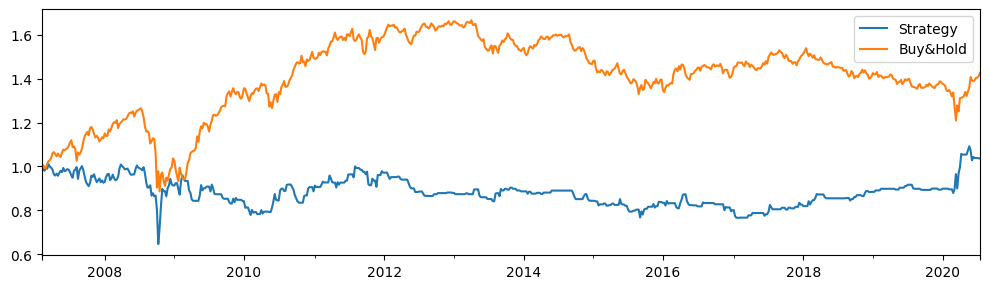



BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: -7.064982614922818e-05
Average Return Given A Signal: -0.00013605914321595866
Volatility: 0.015738807843501082
Volatility Given A Signal: 0.021855637748335228
Sharpe Ratio: -0.032369868584276956
Sharpe Ratio Given A Signal: -0.04489168634744639


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.23537803138373753 % of the time
Flat: 0.48074179743223966 % of the time
Short: 0.2838801711840228 % of the time




{'feature_name': 'FX_AUD_TR_Chg', 'param_grid': {'func': [<function tent at 0x7f4b0296f280>], 'thresh': array([0.        , 0.00056031, 0.00112061, 0.00168092, 0.00224122,
       0.00280153, 0.00336184, 0.00392214, 0.00448245, 0.00504276,
       0.00560306, 0.00616337, 0.00672367, 0.00728398, 0.00784429,
       0.00840459, 0.0089649 , 0.00952521, 0.01008551, 0.01064582])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f4b02955ee0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f4b02aa6a30>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='XG2pd74aGTysevpqknUVFZ')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='jSWRjBTUg576JvKui9eEFF', step=-



BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: 0.0001587506809331639
Average Return Given A Signal: 0.00020456659436424244
Volatility: 0.01760809572207705
Volatility Given A Signal: 0.019992006960884153
Sharpe Ratio: 0.06501369928398225
Sharpe Ratio Given A Signal: 0.07378702365104611


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.4136947218259629 % of the time
Flat: 0.2239657631954351 % of the time
Short: 0.362339514978602 % of the time




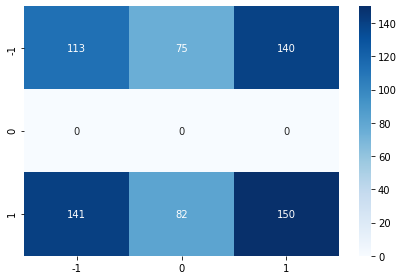

{'feature_name': 'FX_AUD_Daily_Carry_Ann', 'param_grid': {'func': [<function tent at 0x7f4b0296f280>], 'thresh': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])}, 'feature_preprocessing': Pipeline(steps=[('standardscaler-1',
                 StandardScaler(_name='StandardScaler', _new=True, _sep='_',
                                _store_parents_data=False,
                                _suffix='StandardScaler',
                                _uid='PKHrbPiHtLJBuUWVZ5KCLq')),
                ('clipper',
                 Clipper(_name='Clipper', _new=True, _sep='_',
                         _store_parents_data=False, _suffix='Clipper',
                         _uid='NmhDXy4uqaH9s4ntFrp6Yh')),
                ('standardscaler-2',
                 StandardScaler(_name=



BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: 0.000613367475313868
Average Return Given A Signal: 0.0008616645294489407
Volatility: 0.012186127819166346
Volatility Given A Signal: 0.014440324328600044
Sharpe Ratio: 0.362958261354809
Sharpe Ratio Given A Signal: 0.43029167108435723


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.1768901569186876 % of the time
Flat: 0.28815977175463625 % of the time
Short: 0.5349500713266762 % of the time




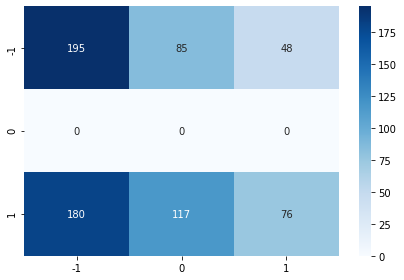

{'feature_name': 'FX_AUD_Daily_Carry_Ann', 'param_grid': {'func': [<function tent at 0x7f4b0296f280>], 'thresh': [0]}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f4b02955ee0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f4af97db3a0>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='XG2pd74aGTysevpqknUVFZ')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='jSWRjBTUg576JvKui9eEFF', step=-1))]), 'target_name': 'FX_AUD_TR', 'model_type': 'not_Substrat'}
Monitor progress at http://10.27.2.239:43895/status
Monitor progress at http://10.27.2.239:43895/status




BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: 0.0008272436281367577
Average Return Given A Signal: 0.0008272436281367577
Volatility: 0.018810582838851606
Volatility Given A Signal: 0.018810582838851606
Sharpe Ratio: 0.3171267306388299
Sharpe Ratio Given A Signal: 0.3171267306388299


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.8288159771754636 % of the time
Flat: 0.0 % of the time
Short: 0.17118402282453637 % of the time




{'feature_name': 'SPGSIN_Chg13', 'param_grid': {'func': [<function tent at 0x7f4b0296f280>], 'thresh': array([0.        , 0.00362402, 0.00724803, 0.01087205, 0.01449607,
       0.01812008, 0.0217441 , 0.02536812, 0.02899214, 0.03261615,
       0.03624017, 0.03986419, 0.0434882 , 0.04711222, 0.05073624,
       0.05436025, 0.05798427, 0.06160829, 0.06523231, 0.06885632])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f4b02955ee0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f4af97db6d0>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='XG2pd74aGTysevpqknUVFZ')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='jSWRjBTUg576JvKui9eEFF', step=-1

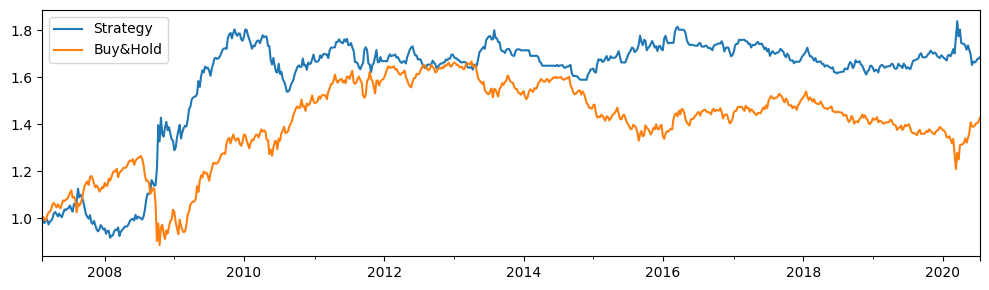



BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: 0.0008073775799186406
Average Return Given A Signal: 0.0009128575540693018
Volatility: 0.018380802552043732
Volatility Given A Signal: 0.019543995067568393
Sharpe Ratio: 0.316748004317473
Sharpe Ratio Given A Signal: 0.3368149354328515


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.42938659058487877 % of the time
Flat: 0.11554921540656206 % of the time
Short: 0.4550641940085592 % of the time




{'feature_name': 'SPGSIN_Chg', 'param_grid': {'func': [<function tent at 0x7f4b0296f280>], 'thresh': array([0.        , 0.00092973, 0.00185945, 0.00278918, 0.0037189 ,
       0.00464863, 0.00557835, 0.00650808, 0.00743781, 0.00836753,
       0.00929726, 0.01022698, 0.01115671, 0.01208643, 0.01301616,
       0.01394589, 0.01487561, 0.01580534, 0.01673506, 0.01766479])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f4b02955ee0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f4af97dbe80>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='XG2pd74aGTysevpqknUVFZ')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='jSWRjBTUg576JvKui9eEFF', step=-1))

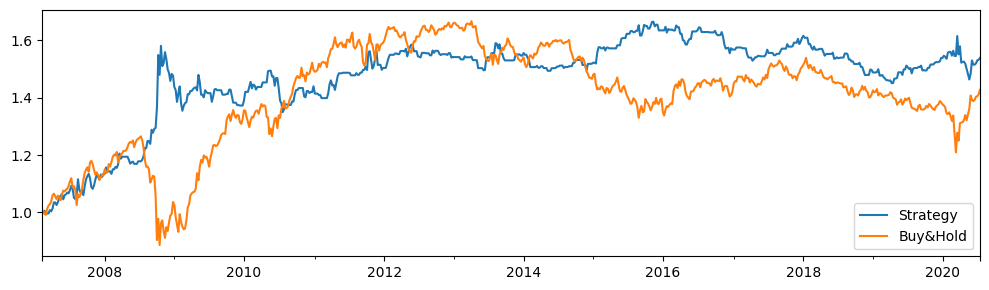



BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: 0.000637446080020528
Average Return Given A Signal: 0.0010296076085124196
Volatility: 0.01608824645951537
Volatility Given A Signal: 0.02044577883431108
Sharpe Ratio: 0.28571722003900335
Sharpe Ratio Given A Signal: 0.36313637706670104


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.30099857346647646 % of the time
Flat: 0.38088445078459343 % of the time
Short: 0.3181169757489301 % of the time




{'feature_name': 'AUD_Trade_Bal', 'param_grid': {'func': [<function tent at 0x7f4b0296f280>], 'thresh': array([  0.        ,  39.31578947,  78.63157895, 117.94736842,
       157.26315789, 196.57894737, 235.89473684, 275.21052632,
       314.52631579, 353.84210526, 393.15789474, 432.47368421,
       471.78947368, 511.10526316, 550.42105263, 589.73684211,
       629.05263158, 668.36842105, 707.68421053, 747.        ])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f4b02955ee0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f4af97db040>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='XG2pd74aGTysevpqknUVFZ')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
           

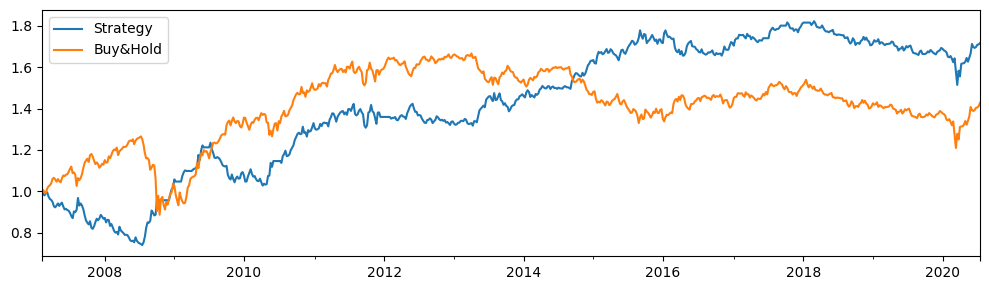



BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: 0.0008958442405952637
Average Return Given A Signal: 0.0009587584926065341
Volatility: 0.01585988832963507
Volatility Given A Signal: 0.016406333674752922
Sharpe Ratio: 0.4073184220673064
Sharpe Ratio Given A Signal: 0.42140468119321983


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.38944365192582026 % of the time
Flat: 0.06562054208273894 % of the time
Short: 0.5449358059914408 % of the time




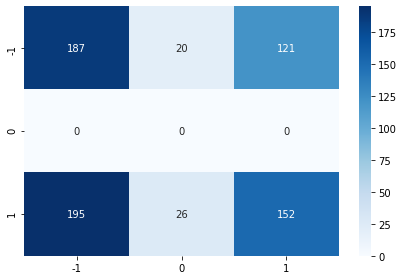

{'feature_name': 'US_AUD_Eq3m', 'param_grid': {'func': [<function short.<locals>.wrapper at 0x7f4af36d73a0>], 'thresh': array([0.        , 0.00187367, 0.00374734, 0.00562101, 0.00749468,
       0.00936835, 0.01124202, 0.01311569, 0.01498936, 0.01686303,
       0.0187367 , 0.02061038, 0.02248405, 0.02435772, 0.02623139,
       0.02810506, 0.02997873, 0.0318524 , 0.03372607, 0.03559974])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f4b02955ee0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f4af987f610>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='XG2pd74aGTysevpqknUVFZ')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='jSWRjBTUg576JvK



BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: 0.0011738825945706486
Average Return Given A Signal: 0.00171079355258633
Volatility: 0.01603759409919386
Volatility Given A Signal: 0.019343456988788102
Sharpe Ratio: 0.5278215497812017
Sharpe Ratio Given A Signal: 0.6377716122985179


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.2225392296718973 % of the time
Flat: 0.31383737517831667 % of the time
Short: 0.463623395149786 % of the time




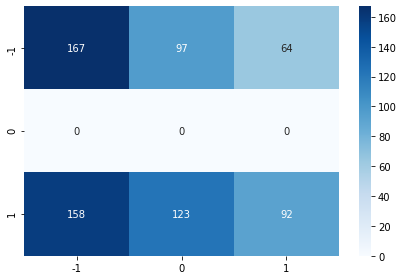

{'feature_name': 'CFTC_AUD_NonComm_NOI', 'param_grid': {'func': [<function tent at 0x7f4b0296f280>], 'thresh': array([0.        , 0.02062025, 0.04124051, 0.06186076, 0.08248102,
       0.10310127, 0.12372153, 0.14434178, 0.16496203, 0.18558229,
       0.20620254, 0.2268228 , 0.24744305, 0.2680633 , 0.28868356,
       0.30930381, 0.32992407, 0.35054432, 0.37116458, 0.39178483])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f4b02955ee0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f4af987ff10>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='XG2pd74aGTysevpqknUVFZ')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='jSWRjBTUg576JvKui9eEFF',

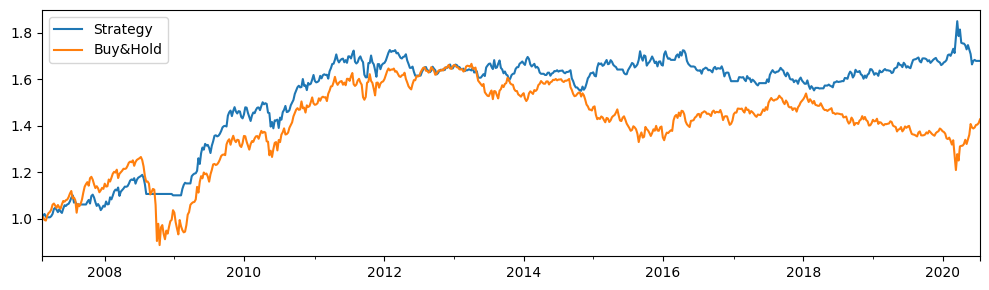



BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: 0.0008549174769129547
Average Return Given A Signal: 0.0009681698728852686
Volatility: 0.015067291095077132
Volatility Given A Signal: 0.016032350528435126
Sharpe Ratio: 0.4091576620972132
Sharpe Ratio Given A Signal: 0.43546778918736806


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.5449358059914408 % of the time
Flat: 0.11697574893009986 % of the time
Short: 0.33808844507845937 % of the time




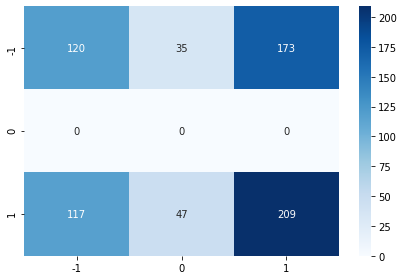

{'feature_name': 'US_2y_v_OIS_ZSc52', 'param_grid': {'func': [<function short.<locals>.wrapper at 0x7f4af36d7670>], 'thresh': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])}, 'feature_preprocessing': None, 'scoring_func': <function mean_score at 0x7f4b02955ee0>, 'splitter': <symawofo.windows.base.DataSplitter object at 0x7f4af987f970>, 'target_preprocessing': Pipeline(steps=[('difference',
                 Difference(_name='Difference', _new=True, _sep='_',
                            _store_parents_data=False, _suffix='Difference',
                            _uid='XG2pd74aGTysevpqknUVFZ')),
                ('lag',
                 Lag(_name='Lag', _new=True, _sep='_',
                     _store_parents_data=False, _suffix='Lag',
                     _uid='jSWRjBTUg

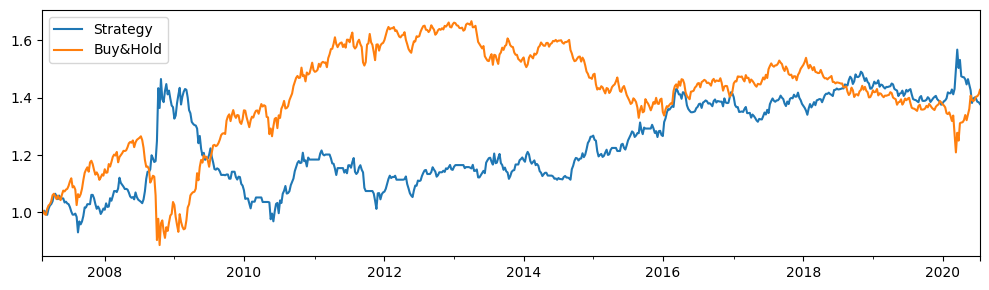



BUY&HOLD STRATEGY
Average Return: 0.00043365827809657557
Average Return Given A Signal: 0.00043365827809657557
Volatility: 0.018825570474985825
Volatility Given A Signal: 0.018825570474985825
Sharpe Ratio: 0.16611206122908237
Sharpe Ratio Given A Signal: 0.16611206122908237




NEW STRATEGY
Average Return: 0.00037763735578524984
Average Return Given A Signal: 0.00042835564143278335
Volatility: 0.01789320324618562
Volatility Given A Signal: 0.019058184361758407
Sharpe Ratio: 0.15219084376126032
Sharpe Ratio Given A Signal: 0.16207821269892128


BUY&HOLD STRATEGY
Long: 0.5320970042796006 % of the time
Flat: 0.0 % of the time
Short: 0.46790299572039945 % of the time


NEW STRATEGY
Long: 0.4122681883024251 % of the time
Flat: 0.11840228245363767 % of the time
Short: 0.4693295292439372 % of the time




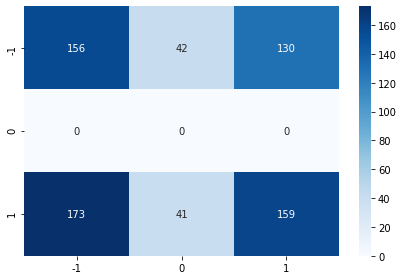

In [38]:
start_date = "2005"
SAVE = True  # This feature does NOT WORK yet. Can't pickle SubStrat unless we move into another file, but then Dask breaks...

if SAVE: 
    path = Path('logs', datetime.now().strftime('%d_%m_%Y_%H_%M_%S'))
    path.mkdir(parents=True)
    
for i, meta in enumerate(tqdm(substrat_meta_list)):
    
    print(meta)
    feature_name = meta['feature_name']
    target_name = meta['target_name']
    param_grid = meta['param_grid']
    splitter = meta['splitter']
    scoring_func = meta['scoring_func']
    feature_preprocessing = meta['feature_preprocessing']
    target_preprocessing = meta['target_preprocessing']
    model_type = meta['model_type']

    features = FeatureFrame(df_master_weekly[[feature_name]].loc[start_date:].copy().dropna())

    target = FeatureFrame(df_master_weekly[[target_name]].loc[start_date:].copy().dropna()).squeeze()
    target = target_preprocessing.fit_transform(target)

    if feature_preprocessing is not None:
        estimator = deepcopy(feature_preprocessing)
        estimator.steps.append(('model', make_model(model_type, param_grid, scoring_func)))
    else:
        estimator = make_model(model_type, param_grid, scoring_func)

    wf = WindowFrame(
        features=features,
        target=target,
        splitter=splitter,
        estimator=estimator
    )

    wf.fit(parallel=True)
    
    # The magic line that solves all our pickling problems...
    SubStrat.__module__ = '__main__'
    SubStratSVR.__module__ = LinearSVR.__module__
    
    if SAVE: 
        file_path = Path(path, f'window_frame_{i:03d}.h5')
        with open(file_path, "wb") as dill_file:
            dill.dump(meta, dill_file)
            dill.dump(wf, dill_file)
            
        meta_path = Path(path, f'window_frame_{i:03d}.json')
        with open(meta_path, 'w') as fp:
            json.dump({k: repr(v) for k, v in meta.items()}, fp, indent=4)
            
    # This next section is wrapped in a function so that we can load new 'wf'...
    # ... and process it without fitting again.
    def post_analysis(wf):
        signal = ThresholdSignSignal(wf, threshold=0)

        my_signals = signal.get_signals()
        optimal_signals = np.sign(wf.target.data).reindex(my_signals.index)

        strat_pnl = PNL(signal, asset_type=AssetType(level=False, log=True))

        buyhold_pnl = PNL(LongOnly(wf.target, my_signals.index), 
                          asset=wf.target.data,
                          asset_type=AssetType(level=False, log=True))

        fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=100)
        strat_pnl.get_pnl().plot(label='Strategy')
        buyhold_pnl.get_pnl().plot(label='Buy&Hold')
        ax.legend()
        plt.tight_layout()
        plt.show()

        

        def return_stats(rets, name=None):
            print('\n')
            
            if name: print(name)
            print(f'Average Return: {rets.mean()}')
            print(f'Average Return Given A Signal: {rets[rets.abs()>0].mean()}')

            print(f'Volatility: {rets.std()}')
            print(f'Volatility Given A Signal: {rets[rets.abs()>0].std()}')

            print(f'Sharpe Ratio: {np.sqrt(52)*rets.mean()/rets.std()}')
            print(f'Sharpe Ratio Given A Signal: {np.sqrt(52)*rets[rets.abs()>0].mean()/rets[rets.abs()>0].std()}')

            print('\n')

        return_stats(buyhold_pnl.get_returns(), 'BUY&HOLD STRATEGY')
        return_stats(strat_pnl.get_returns(), 'NEW STRATEGY')

        def signal_stats(signals, name=None):
            if name: print(name)
            print(f'Long: {(signals>0).mean()} % of the time')
            print(f'Flat: {(signals==0).mean()} % of the time')
            print(f'Short: {(signals<0).mean()} % of the time')
            print('\n')

        signal_stats(optimal_signals, 'BUY&HOLD STRATEGY')
        signal_stats(my_signals, 'NEW STRATEGY')

        labels = [-1, 0, 1]
        cm = sk.metrics.confusion_matrix(optimal_signals.astype(int).values, my_signals.astype(int).values, labels=labels)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
        ax.set(xlabel='Predicted', ylabel='True')
        plt.tight_layout()
        plt.show()
        
    post_analysis(wf)

# Logs

In [ ]:
!ls logs/

In [ ]:
# folder_path = Path('logs')
# folder_path = folder_path.d
folder_path = Path('logs', '02_12_2020_19_08_54')

meta_list, wf_list = [], []
for file_path in tqdm(sorted(list(folder_path.glob('*.h5')))):
    with open(file_path, "rb") as dill_file:
        meta_list.append(dill.load(dill_file))
        wf_list.append(dill.load(dill_file))

In [ ]:
results = []
names = [i['feature_name'] for i in substrat_meta_list]
df_thresh = pd.DataFrame(columns=names)

for wf, name in tqdm(list(zip(wf_list, names))):
    signal = ThresholdSignSignal(wf)
    results.append(signal.signals)
    
    is_pipeline = isinstance(wf[0].estimator, Pipeline)
    for w in wf:
        if is_pipeline:
            estimator = w.estimator[-1]
        else:
            estimator = w.estimator
        df_thresh.loc[w.training_end, name] = estimator.best_params_['thresh']
        
        

In [ ]:
for i in df_thresh:
    df_thresh[i].plot(title=i)
    plt.show()

In [ ]:
signals = pd.concat(results, axis=1)
signals.columns = [i['feature_name']+str(n) for n,i in enumerate(substrat_meta_list)]


In [ ]:
for i in signals.columns:
    signals[i].plot(title=i)
    plt.show()

# Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr

def plot_dendrogram(model, strats, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    R = dendrogram(linkage_matrix, labels=strats.columns, leaf_rotation=90, **kwargs)
    
    return R

def effective_weight_2by2(strats, plot=True):
    cl = AgglomerativeClustering(linkage='complete', affinity='precomputed', 
                             distance_threshold=0, n_clusters=None)
    d_mat  = np.sqrt(1-strats.dropna().corr(method='pearson'))
    cl.fit(d_mat)
    
    if plot: 
        R = plot_dendrogram(cl, strats)
    
    def find_ancestor(model, target):
        for ind,pair in enumerate(model.children_):
            if target in pair:
                return [target]+find_ancestor(model, model.n_leaves_+ind)
        return [ind+model.n_leaves_]

    output = pd.Series(index=strats.columns, dtype='float64')
    for i, col in enumerate(strats):
        depth = len(find_ancestor(cl, i))-1
        output[col] = 0.5**depth
    return output

def effective_weight_even(strats, n_clusters=2):
    d_mat  = np.sqrt(1-strats.dropna().corr(method='pearson'))
    
    cl = AgglomerativeClustering(linkage='complete', affinity='precomputed', n_clusters=n_clusters)
    d_mat  = np.sqrt(1-strats.dropna().corr(method='pearson'))
    labels = cl.fit_predict(d_mat)
    unique_labels = np.unique(labels)
    
    output = pd.Series(data=np.ones(len(strats.columns)), index=strats.columns, dtype='float64')
    for label in unique_labels:
        idx = np.where(labels==label)[0]
        output.iloc[idx] = 1/(len(idx)*len(unique_labels))
    return output

In [ ]:
signals = pd.concat(results, axis=1)
strats = signals.multiply(df_master_weekly[asset].diff(), axis=0).astype(float)
strats.columns = [i['feature_name']+str(n) for n,i in enumerate(substrat_meta_list)]
strats = strats.dropna()

weight_2by2_cluster = effective_weight_2by2(strats, plot=True)
strats_2by2_cluster = weight_2by2_cluster * strats * len(weight_2by2_cluster)

N_CLUSTERS = 3  # SET THIS BY OBSERVING THE DENDROGRAM!
weight_even_cluster = effective_weight_even(strats, n_clusters=N_CLUSTERS)
strats_even_cluster = weight_even_cluster * strats * len(weight_even_cluster)

list_of_strats = [
    ('Buy&Hold', df_master_weekly[asset].diff().reindex(strats.index)),
    ('Equally Weighted', strats.mean(axis=1)),
    ('Equal Within Cluster', strats_even_cluster.mean(axis=1)),
    ('2by2 Weighted Clustering', strats_2by2_cluster.mean(axis=1)),
]

# NORMALISE BY VOL!!!
# for i in range(len(list_of_strats)):
#     list_of_strats[i] = (list_of_strats[i][0], list_of_strats[i][1]/list_of_strats[i][1].std())

def return_stats(rets, name=None):
    print('\n')

    if name: print(name)
    print(f'Average Return: {rets.mean()}')
    print(f'Average Return Given A Signal: {rets[rets.abs()>0].mean()}')

    print(f'Volatility: {rets.std()}')
    print(f'Volatility Given A Signal: {rets[rets.abs()>0].std()}')

    print(f'Sharpe Ratio: {np.sqrt(52)*rets.mean()/rets.std()}')
    print(f'Sharpe Ratio Given A Signal: {np.sqrt(52)*rets[rets.abs()>0].mean()/rets[rets.abs()>0].std()}')

    print('\n')

for name, rets in list_of_strats:
    return_stats(rets, name=name)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for name, rets in list_of_strats:
    rets.cumsum().plot(ax=ax, label=name)
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
signals.mean(axis=1).plot(ax=ax, label='Equally Weighted')
(signals*weight_even_cluster.values*len(weight_even_cluster)).mean(axis=1).plot(ax=ax, label='Equal Within Cluster')
(signals*weight_2by2_cluster.values*len(weight_2by2_cluster)).mean(axis=1).plot(ax=ax, label='2by2 Weighted Clustering')
ax.legend()
plt.show()

In [ ]:
pd.concat([weight_even_cluster,weight_2by2_cluster,pd.Series(1/strats.shape[1], index=strats.columns)], axis=1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11), dpi=150)
sns.heatmap(strats.dropna().astype(float).corr(), cmap='Blues', ax=ax, annot=True, fmt='.2f')
plt.show()